In [1]:
import numpy as np
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


inf=float("inf")

Training will be faster if you have a GPU. You could use Google Colab although they are getting more restrictive to provide GPU instances for non-paying users.

In [2]:
#device = torch.device("cuda:0")
device = torch.device("cpu:0")

In [3]:
## loading the data: point clouds and diagrams
dirPath = "./data/"
diagrams = np.load(dirPath + "/diagrams.npy", allow_pickle=True)
y = np.load(dirPath + "/pointclouds_y.npy", allow_pickle=True)

In [11]:
# len(y), set(y)
len(diagrams[0])
diagrams[0]
len(diagrams[0][1])

217

The following part is exactly the same as in the previous notebook, it's just to prepare the input to the neural network: it will be by default the stable ranks for H1 with no contour or anything.

In [4]:
## Parameters
H = "H1"
w_p = inf

density = False
mu = 0.15
sigma = 0.05

limit = 1000

classes_chosen = [0, 1, 2, 3, 4]

In [5]:
#correspondence by index of: 
barLengths = [] # bars of diagram, sorted by length, with a possible density transformation 
ys = [] # class of the diagram
the_dgs = [] # actual diagram

random_inds = np.random.choice(1000, size=limit, replace=False)
#random_inds = list(range(1000))

for c in classes_chosen:

  #for dg in diagrams[y==c][:limit,:]:
  for dg in diagrams[y==c][random_inds]:
    if H=="H1":
      if density:
        barLengths.append(np.sort(norm.cdf(dg[1][:,1], loc=mu, scale=sigma) - norm.cdf(dg[1][:,0], loc=mu, scale=sigma)))
      else:
        barLengths.append(np.sort(dg[1][:,1] - dg[1][:,0]))

      the_dgs.append(dg[1])

    elif H=="H0":
      if density:
        barLengths.append(np.sort(norm.cdf(dg[0][:-1,1], loc=mu, scale=sigma) - norm.cdf(dg[0][:-1,0], loc=mu, scale=sigma)))
      else:
        barLengths.append(np.sort(dg[0][:-1,1] - dg[0][:-1,0]))

      the_dgs.append(dg[0])

    ys.append(c)

sizes = [len(i) for i in barLengths] # extract the number of bars for each diagram

if w_p != inf:

  barLengths2 = []

  for b in barLengths:
    barLengths2.append(np.cumsum(b ** w_p) ** (1 / w_p))

  barLengths = barLengths2 # Lp norms



In [6]:
indices = list(range(len(barLengths)))

indTrain, indTest, yTrain, yTest = train_test_split(indices, ys, test_size=0.2)

In [7]:
len(barLengths)

5000

In [8]:
maxSize = np.max([i.shape[0] for i in barLengths]) # the max number of bars among diagrams

vecs = np.zeros((len(barLengths), maxSize)) # matrix num_diags x max_possible_len_of_each_dg

for i in range(len(barLengths)):
  vecs[i, :barLengths[i].shape[0]] = np.sort(barLengths[i])[::-1] # at each row the  diagram by increasing values (where available)


In [9]:
matrixSTens = torch.from_numpy(vecs) # cast to tensor all vectors

- _matrixSTens_ will contain the vectors we use as input to the neural network.

In [10]:
matrixSTens.shape

torch.Size([5000, 288])

# Neural network boiler plate

The classes and functions below are just standard PyTorch Dataset and code to report accuracy on test set (but please check in case you see some problem with it :-) 

In [11]:
class TheDataset(Dataset):
  def __init__(self,x,y):
    self.x = x
    self.y = y
    self.length = len(x)

  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

def test(dataloader, model, loss_fn, p):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    preds = []
    ground_truth = []
    with torch.no_grad():
        for X, y in dataloader:
          pred = model(X.float().to(device), p)
          #return pred, y
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
          preds.append(pred.argmax(1))
          ground_truth.append(y)
    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct, preds, ground_truth

In [12]:
trainset = TheDataset(matrixSTens[indTrain,:], torch.tensor(yTrain).to(device))
trainloader = DataLoader(trainset,batch_size=4000,shuffle=False)

In [13]:
testset = TheDataset(matrixSTens[indTest,:], torch.tensor(yTest).to(device))
testloader = DataLoader(testset,batch_size=1000,shuffle=False)

# L inf layer

Now we enter the meat of the project.

I define the layer and its forward function which just uses PyTorch cdist to compute all distances between the batch and the parameter vectors. One can also pass in _p_ because in the paper they suggest that although in the end we want $p=\infty$ it can be good to train with schedules increasing in value, so this is something we can try.

The initialization of the parameters has a huge importance and this is something we should think about and experiment with, this you can see in the constructor. Here I initialize the parameters of the first layer to have the same scale (mean and standard deviation) as the data (I think this is ok to do, let me know what you think. We should only do it based on the training set however not on the whole data as I do it now, but I don't think it will have a big impact). For the next layers I just initialize it based on a bit of trial and error...


Also note that there is in fact some code that comes with the paper https://arxiv.org/pdf/2102.05363 but I chose to build it from scratch to get a better understanding. We could however compare to their code later.

In [14]:
class linfLayer(nn.Module):

    def __init__(self, in_blocks, out_blocks, layer_num):
        super().__init__()

        self.layer_num = layer_num

        if layer_num==1:
          params = matrixSTens.mean(axis=0) + torch.randn((out_blocks, in_blocks)) * matrixSTens.std(axis=0) # normalization
          self.params = torch.nn.Parameter(data=params.float().to(device))

        else:
          params = torch.randn((out_blocks, in_blocks)) * 0.05

          self.params = torch.nn.Parameter(data=params.float().to(device))

    def forward(self, x, p):

        res = torch.cdist(x, self.params, p=p) #torch.cdist but with custom params

        return res

We combine several (3 in this case) layers in a model below.

Here the important step is that we in the forward method center the data (kind of batch normalization but only the centering part, not dividing by standard deviation because that would break the Lipschitzness).

In [15]:
class linfModel(nn.Module):
  def __init__(self):
    super(linfModel,self).__init__()

    self.layer1 = linfLayer(in_blocks=288, out_blocks=300, layer_num=1)
    self.layer2 = linfLayer(in_blocks=300, out_blocks=100, layer_num=2)
    self.layer3 = linfLayer(in_blocks=100, out_blocks=5, layer_num=3)

  def forward(self, x, p):
    x = self.layer1(x, p)
    x = x - x.mean(axis=0)
    x = self.layer2(x, p)
    x = x - x.mean(axis=0)
    x = self.layer3(x, p)
    
    return x

  def get_embs(self, x, p):
    x = self.layer1(x, p)
    x = x - x.mean(axis=0)
    #x = self.layer2(x, p)
    return x

In [16]:
epochs = 100

# Model , Optimizer, Loss
model = linfModel().to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05, eps=1e-06)

In [17]:
list(model.parameters())[0].shape

torch.Size([300, 288])

The schedule is if we want to train first with lower values of $p$ (see the paper). If you just want $p=\infty$ from all epochs you can do as below.

In [18]:
p_schedule = np.ones(epochs)*inf

This is a standard training loop but with a detail that makes a big difference: you notice that I inflate the logits before PyTorch computes the softmax and the cross entropy loss.

This is what is called the "temperature" of the softmax (see e.g. https://medium.com/@harshit158/softmax-temperature-5492e4007f71#:~:text=Temperature%20is%20a%20hyperparameter%20of%20LSTMs%20(and%20neural%20networks%20generally,utilize%20the%20Softmax%20decision%20layer.)

We need to think about this and experiment, I'm not clear about why it improves things. But what is important is that it doesn't impact the prediction of the network (since scaling the logits doesn't change the order, so the "winning class" with the highest logit is still the same, but it impacts the training and seems to make it easier in our case). There may be non-desired effects however, for instance maybe logits will become too compressed and this will lead to low robustness, that's something we should look at later).

The training is a bit unstable sometimes so run it several times!

In [19]:
%%time
losses = []
for i in range(epochs):
  for j,(x_t,y_t) in enumerate(trainloader):

    #calculate output
    output = model(x_t.float().to(device), p_schedule[i])
    output2 = output*100


    y_t = y_t.long()
    #calculate loss
    loss = loss_fn(output2, y_t)

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%1 == 0:
    losses.append(loss)
    print("epoch {}\tloss : {}, p: {}".format(i,loss, p_schedule[i]))

epoch 0	loss : 2.058633327484131, p: inf
epoch 1	loss : 1.7896616458892822, p: inf
epoch 2	loss : 1.4979101419448853, p: inf
epoch 3	loss : 2.810214042663574, p: inf
epoch 4	loss : 2.3779633045196533, p: inf
epoch 5	loss : 2.4536006450653076, p: inf
epoch 6	loss : 1.7067502737045288, p: inf
epoch 7	loss : 1.2071689367294312, p: inf
epoch 8	loss : 1.227992057800293, p: inf
epoch 9	loss : 1.4182642698287964, p: inf
epoch 10	loss : 1.0457887649536133, p: inf
epoch 11	loss : 0.8863292336463928, p: inf
epoch 12	loss : 0.927786111831665, p: inf
epoch 13	loss : 1.0944831371307373, p: inf
epoch 14	loss : 1.033191442489624, p: inf
epoch 15	loss : 0.8340880274772644, p: inf
epoch 16	loss : 0.8209742307662964, p: inf
epoch 17	loss : 0.9597315788269043, p: inf
epoch 18	loss : 0.9173004627227783, p: inf
epoch 19	loss : 0.8004856705665588, p: inf
epoch 20	loss : 0.8246299624443054, p: inf
epoch 21	loss : 0.8739787936210632, p: inf
epoch 22	loss : 0.8641759753227234, p: inf
epoch 23	loss : 0.81434643

In [20]:
test_loss, correct, preds, ground_truth = test(testloader, model, loss_fn, p=inf)

In [21]:
correct

0.71

<Axes: >

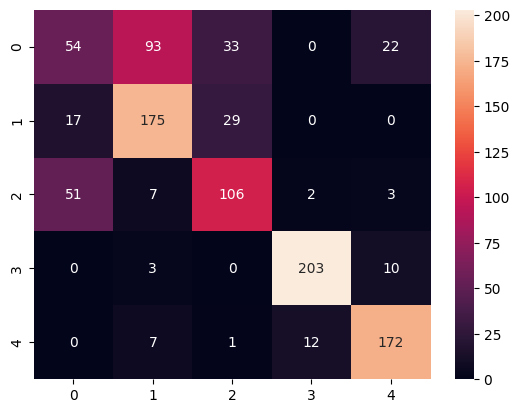

In [22]:
cfm = confusion_matrix(ground_truth[0].cpu().numpy(), preds[0].cpu().numpy())
sns.heatmap(cfm, annot=True, fmt='g')

# Checking the output

Below I have some code to check the margin (difference between the logits for the "winning class" and the next biggest one), as this is what is used to compute the robustness (see the "Towards Certifying l∞ Robustness using Neural Networks with l∞-dist Neurons" paper). This should be changed to only look at it for samples that are correctly classified, and also looking separately at train and test set to see if there is any difference).

We then need to relate this back to the Wasserstein/bottleneck distances and try to understand what it means there.

In [23]:
output = model(matrixSTens.float().to(device), p=inf)

In [24]:
output

tensor([[0.3254, 0.3304, 0.3278, 0.2967, 0.3011],
        [0.3505, 0.3011, 0.3282, 0.2673, 0.3263],
        [0.3255, 0.3328, 0.3242, 0.2991, 0.3001],
        ...,
        [0.3207, 0.2346, 0.3187, 0.3016, 0.3503],
        [0.3300, 0.2405, 0.3300, 0.2914, 0.3438],
        [0.3237, 0.2216, 0.3224, 0.3201, 0.3636]], grad_fn=<CdistBackward0>)

In [25]:
output_sorted = torch.sort(output, dim=1, descending=True)[0]

In [26]:
output_diff = output_sorted[:,0] - output_sorted[:,1]

In [27]:
(output_diff).mean()

tensor(0.0196, grad_fn=<MeanBackward0>)

Next I compute the distances between all samples:
- Between stable ranks
- Between the representation learned by the neural network (output logits, 5 dimensional)

This will be very important to look closely at:
- Distance between the NN representations should never be larger than the distance between stable ranks because we are using the Lipschitz layer, but we should verify this!
- How much does it "compress" things, for instance at a first look the distance between the representations seems to be equal to the distance between stable ranks for many samples. What is going on there, how can that be the case?

In [28]:
distMatStab = torch.cdist(matrixSTens, matrixSTens, p=inf)


In [29]:
distMatRep = torch.cdist(output, output, p=inf).to("cpu")

In [30]:
factors = distMatRep / distMatStab

In [31]:
factors[torch.isnan(factors)] = 0

In [32]:
factors.mean()

tensor(0.9564, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [33]:
factors.max()

tensor(1.0004, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [34]:
factors

tensor([[0.0000, 1.0000, 0.7627,  ..., 0.9575, 1.0000, 0.9187],
        [1.0000, 0.0000, 1.0000,  ..., 0.9399, 1.0000, 0.8919],
        [0.7627, 1.0000, 0.0000,  ..., 0.9585, 1.0000, 0.9203],
        ...,
        [0.9575, 0.9399, 0.9585,  ..., 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 1.0000],
        [0.9187, 0.8919, 0.9203,  ..., 1.0000, 1.0000, 0.0000]],
       dtype=torch.float64, grad_fn=<IndexPutBackward0>)